# Build a GitHub Issue Resolver Agent

In this recipe, we'll create a **GitHub Issue Resolver Agent with Anthropic Claude 4 Sonnet**. Given an issue URL, the agent will:  

- Fetch and parse the issue description and comments  
- Identify the relevant repository, directories, and files  
- Retrieve and process file content  
- Determine the next steps for resolution and post them as a comment  

For this, we'll use the new [Agent](https://docs.haystack.deepset.ai/docs/agent) component. **`Agent`** is a Haystack component that implements a tool-calling functionality with provider-agnostic chat model support. We can use `Agent` either as a standalone component or within a pipeline.

Here's what our **GitHub Issue Resolver Pipeline** looks like:

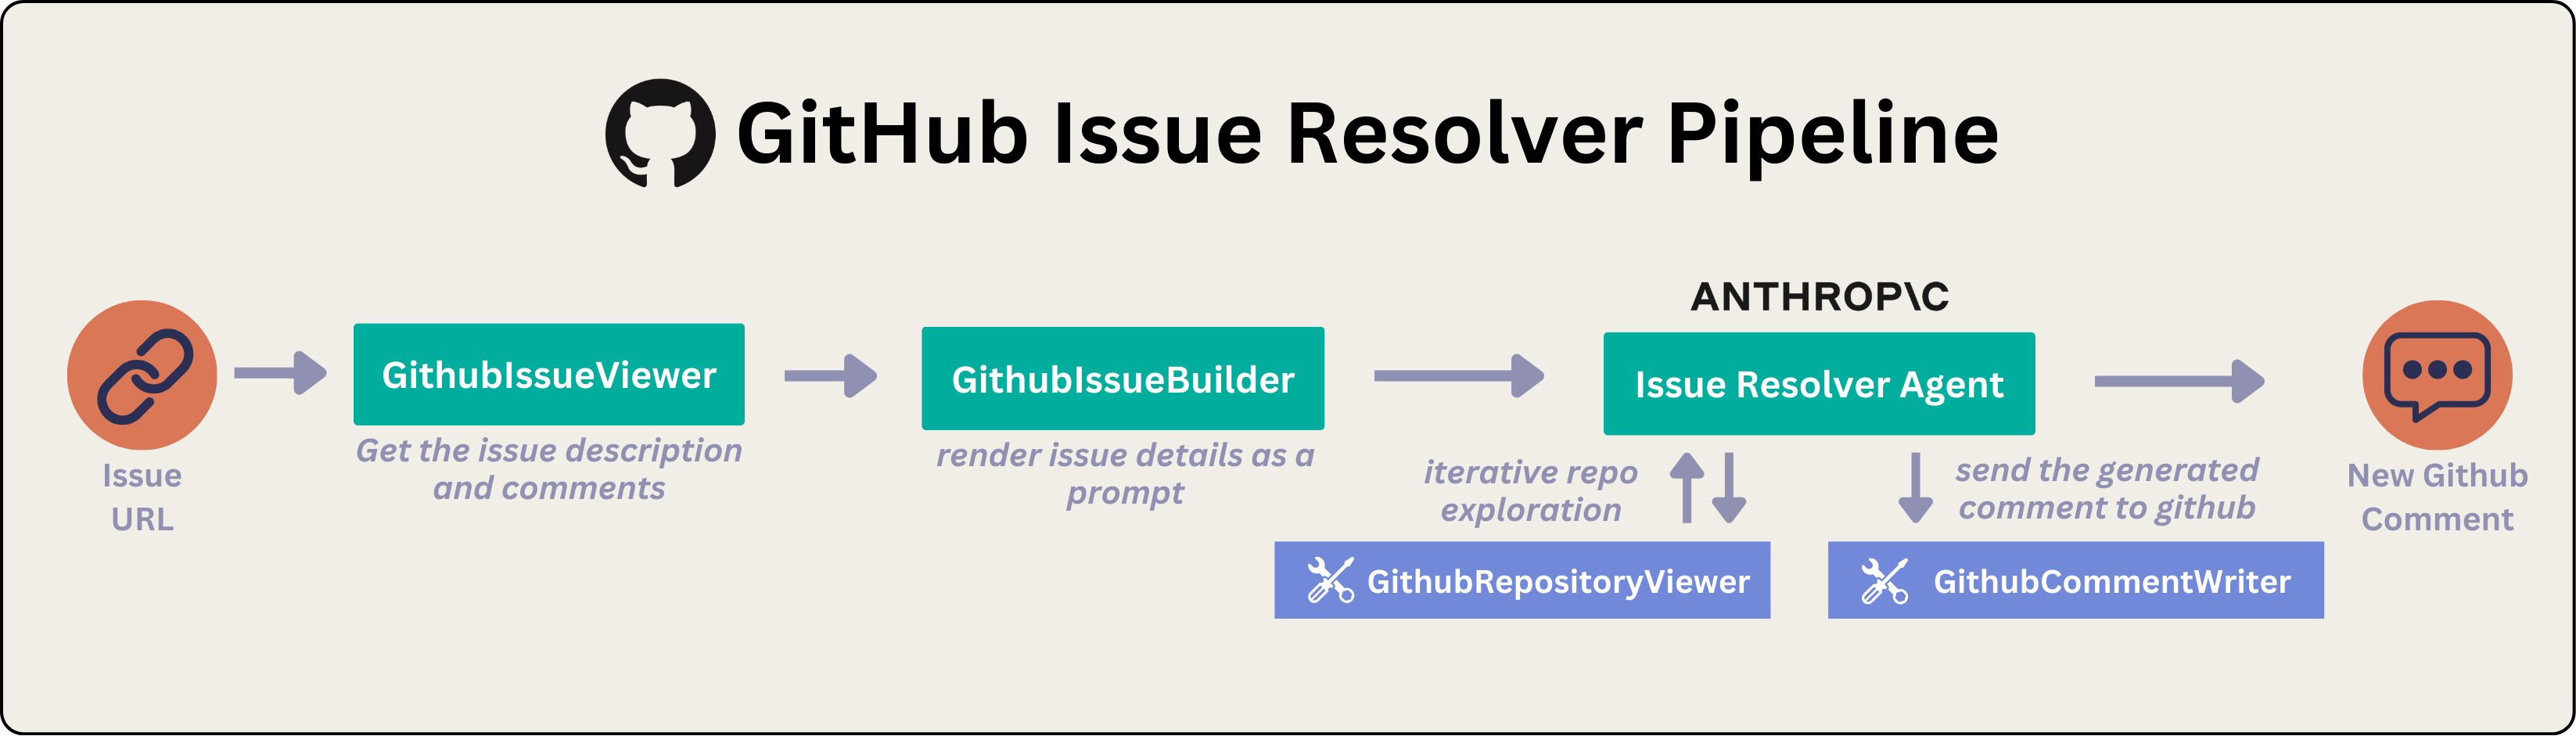

## Install dependencies

In [ ]:
!pip install anthropic-haystack github-haystack -q

In [2]:
import os
from getpass import getpass
from typing import List

from haystack import logging, Document,Pipeline
from haystack.components.agents import Agent
from haystack.components.builders import ChatPromptBuilder
from haystack.dataclasses import ChatMessage
from haystack.tools.from_function import tool
from haystack_integrations.components.generators.anthropic.chat.chat_generator import AnthropicChatGenerator

In [3]:
logger = logging.getLogger(__name__)

## Initialize a `GitHubIssueViewer` component
The `GitHubIssueViewer` component takes a GitHub issue URL and returns a list of Haystack documents. The first document contains the main issue content, while the subsequent documents contain the issue comments.

In [4]:
from haystack_integrations.components.connectors.github import GitHubIssueViewer
issue_viewer = GitHubIssueViewer()
issue_viewer.run(url="https://github.com/deepset-ai/haystack/issues/8903")["documents"]

[Document(id=401aeab38ff82756caddcf20be6191917e0a8d262347f4acc2adb24869c842e9, content: '**Is your feature request related to a problem? Please describe.**
 Most of our components require so...', meta: {'type': 'issue', 'title': 'Proposal to make input variables to `PromptBuilder` and `ChatPromptBuilder` required by default', 'number': 8903, 'state': 'closed', 'created_at': '2025-02-21T14:03:22Z', 'updated_at': '2025-03-21T14:53:27Z', 'author': 'sjrl', 'url': 'https://github.com/deepset-ai/haystack/issues/8903'}),
 Document(id=463748463715f2c4f988273caf73d5006e5a95beeecd04c91a142fa93ce78354, content: 'Old related issue: https://github.com/deepset-ai/haystack/issues/7441', meta: {'type': 'comment', 'issue_number': 8903, 'created_at': '2025-02-21T14:07:54Z', 'updated_at': '2025-02-21T14:07:54Z', 'author': 'anakin87', 'url': 'https://github.com/deepset-ai/haystack/issues/8903#issuecomment-2674648879'}),
 Document(id=d7eb9351f9c74a0d8eac616bfc92f97e06bdb6276c54b3e6ec437e3fc7378cb2, content

## Initialize a `GitHubRepoViewer` Tool

This tool retrieves content from a GitHub repository based on a given `repo` and `path`:

- If the `path` points to a **directory**, it returns a list of Documents—one per item—where each document contains the item's name (file or directory) along with full path and metadata in `Document.meta`.  
- If the `path` points to a **file**, it returns a single Document containing the file content, with full path and metadata in `Document.meta`.  
- If an **error** occurs, it returns a single Document with the error message, and `Document.meta` includes `type="error"`.  

In [5]:
from haystack_integrations.tools.github import GitHubRepoViewerTool
github_repo_viewer_tool = GitHubRepoViewerTool()

## Mocked `GitHubIssueCommenter` Tool from a function

With the [`@tool`](https://github.com/deepset-ai/haystack-experimental/blob/7e88f2a4e4310359e6c76a6ce8ff920d1bb841f7/haystack_experimental/tools/from_function.py#L137) decorator, we can easily convert a function into a tool, using its docstring as the description.

Now, let's create a tool (a mockup) that allows the agent to write comments on GitHub issues. This tool will also serve as the agent's exit condition, signaling when it has completed its task.

If you want, you can replace this mockup later with `GitHubIssueCommenterTool`. You will need a GitHub Personal Access Token to enable commenting on GitHub. The [GitHub-Haystack integration page](https://haystack.deepset.ai/integrations/github) has all the details.

In [6]:
@tool
def write_github_comment(comment: str) -> str:
    """
    Use this to create a comment on GitHub once you finished your exploration.
    """
    return comment

## Create the "Issue Resolver Agent" with Tools  

To initialize the agent, we need:  
1. A list of tools (✅)   
2. A chat generator  
3. A system prompt

We'll start by creating the `ChatGenerator`. In this example, we'll use the [AnthropicChatGenerator](https://docs.haystack.deepset.ai/docs/anthropicchatgenerator) with the `claude-sonnet-4-20250514` model.

In [7]:
os.environ["ANTHROPIC_API_KEY"] = getpass("Anthropic Key: ")

Anthropic Key: ··········


In [8]:
chat_generator = AnthropicChatGenerator(model="claude-sonnet-4-20250514", generation_kwargs={"max_tokens": 8000})

In this example, we'll use a pre-defined system prompt, guiding the agent to analyze GitHub issues, explore the repository for relevant files, and generate a detailed comment with resolution steps. Of course, you can use your own custom prompt instead.

In [9]:
from haystack_integrations.prompts.github import SYSTEM_PROMPT
print(SYSTEM_PROMPT[:100]+"...")

The assistant is Haystack-Agent, created by deepset.
Haystack-Agent helps developers to develop soft...


Finally, we create the agent using `chat_generator`, `SYSTEM_PROMPT`, and `tools`. We set `exit_conditions=["write_github_comment"]` to ensure the agent stops once the `write_github_comment` tool is used. For `state_schema`, we define `{"documents": {"type": List[Document]}}`, allowing the agent to accumulate documents retrieved from tools, such as `github_repo_viewer_tool`.

In [18]:
issue_resolver_agent = Agent(
    chat_generator=chat_generator,
    system_prompt=SYSTEM_PROMPT,
    tools=[github_repo_viewer_tool, write_github_comment],
    exit_conditions=["write_github_comment"],
    state_schema={"documents": {"type": List[Document]}},
)

> 💡 Tip: You can pass the built-in `print_streaming_chunk` or your custom function to `Agent` to enable streaming and see the tool calls and results in real time.

```python
from haystack.components.generators.utils import print_streaming_chunk

issue_resolver_agent = Agent(
    chat_generator=chat_generator,
    system_prompt=SYSTEM_PROMPT,
    tools=[github_repo_viewer_tool, write_github_comment],
    exit_conditions=["write_github_comment"],
    state_schema={"documents": {"type": List[Document]}},
    streaming_callback=print_streaming_chunk
)
```

## Construct the Issue Resolver Pipeline  

With all components in place, we can now assemble the issue resolver pipeline.

In [19]:
issue_viewer = GitHubIssueViewer()
issue_template = """
Issue from: {{ url }}
{% for document in documents %}
{% if loop.index == 1 %}
**Title: {{ document.meta.title }}**
{% endif %}
<issue-comment>
{{document.content}}
</issue-comment>
{% endfor %}
"""

issue_builder = ChatPromptBuilder(template=[ChatMessage.from_user(issue_template)], required_variables="*")

issue_resolver = Pipeline()
issue_resolver.add_component("issue_viewer", issue_viewer)
issue_resolver.add_component("issue_builder", issue_builder)
issue_resolver.add_component("issue_resolver_agent", issue_resolver_agent)

issue_resolver.connect("issue_viewer.documents", "issue_builder.documents")
issue_resolver.connect("issue_builder.prompt", "issue_resolver_agent.messages")

🚅 Components
  - issue_viewer: GitHubIssueViewer
  - issue_builder: ChatPromptBuilder
  - issue_resolver_agent: Agent
🛤️ Connections
  - issue_viewer.documents -> issue_builder.documents (List[Document])
  - issue_builder.prompt -> issue_resolver_agent.messages (List[ChatMessage])

## Let's Try Our Pipeline  

Now, let's run the pipeline with an issue URL and see the agent in action.

In [ ]:
issue_url = "https://github.com/deepset-ai/haystack-core-integrations/issues/1819"
result = issue_resolver.run({"url": issue_url})

Let's see the comment generated by our pipeline to resolve the given issue.

In [32]:
print(result["issue_resolver_agent"]["last_message"].tool_call_result.result)

# Implementation: Adding `component_info` Support to `AmazonBedrockChatGenerator`

I've analyzed the codebase and the PR mentioned in the issue. Here's my proposed implementation to add `component_info` support to `AmazonBedrockChatGenerator`, following the same pattern used in the main Haystack repository.

## Changes Required

### 1. Update Imports in `utils.py`

The `ComponentInfo` class needs to be imported:

```python
from haystack.dataclasses import (
    AsyncStreamingCallbackT,
    ChatMessage,
    ChatRole,
    ComponentInfo,  # Add this import
    StreamingChunk,
    SyncStreamingCallbackT,
    ToolCall,
)
```

### 2. Update `_convert_event_to_streaming_chunk` Function

Modify the function signature to accept an optional `component_info` parameter and include it in all `StreamingChunk` creations:

```python
def _convert_event_to_streaming_chunk(
    event: Dict[str, Any], 
    model: str, 
    component_info: Optional[ComponentInfo] = None
) -> StreamingChunk:
    """
    Con

In [ ]:
# Render it in markdown format
from IPython.display import Markdown, display

display(Markdown("# Comment from Agent\n\n" + result["issue_resolver_agent"]["last_message"].tool_call_result.result))

By checking other `messages`, you can observe the iterative process of our Issue Resolver Agent as it generates the GitHub comment, making tool calls and processing their results step by step.

In [ ]:
result["issue_resolver_agent"]["messages"]

We can also investigate the files our Agent looked at:

In [35]:
for document in result["issue_resolver_agent"]["documents"]:
    if document.meta["type"] in ["file_content"]:
        display(Markdown(f"[{document.meta['url']}]({document.meta['url']})"))

[https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/amazon_bedrock/src/haystack_integrations/components/generators/amazon_bedrock/chat/chat_generator.py](https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/amazon_bedrock/src/haystack_integrations/components/generators/amazon_bedrock/chat/chat_generator.py)

[https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/amazon_bedrock/src/haystack_integrations/components/generators/amazon_bedrock/chat/utils.py](https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/amazon_bedrock/src/haystack_integrations/components/generators/amazon_bedrock/chat/utils.py)

[https://github.com/deepset-ai/haystack/blob/main/haystack/dataclasses/streaming_chunk.py](https://github.com/deepset-ai/haystack/blob/main/haystack/dataclasses/streaming_chunk.py)

[https://github.com/deepset-ai/haystack/blob/main/haystack/components/generators/chat/openai.py](https://github.com/deepset-ai/haystack/blob/main/haystack/components/generators/chat/openai.py)

[https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/amazon_bedrock/tests/test_chat_generator.py](https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/amazon_bedrock/tests/test_chat_generator.py)